# CelebA images

In [1]:
%matplotlib inline

import sys
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import torch

sys.path.append("../../")
from experiments.datasets import FFHQStyleGAN2DLoader
from experiments.architectures.image_transforms import create_image_transform, create_image_encoder
from experiments.architectures.vector_transforms import create_vector_transform
from manifold_flow.flows import ManifoldFlow, EncoderManifoldFlow
import plot_settings as ps


In [2]:
ps.setup()

## Helper function to go from torch to numpy conventions

In [3]:
def trf(x):
    return np.clip(np.transpose(x, [1,2,0]) / 256., 0., 1.)

## Sample comparison

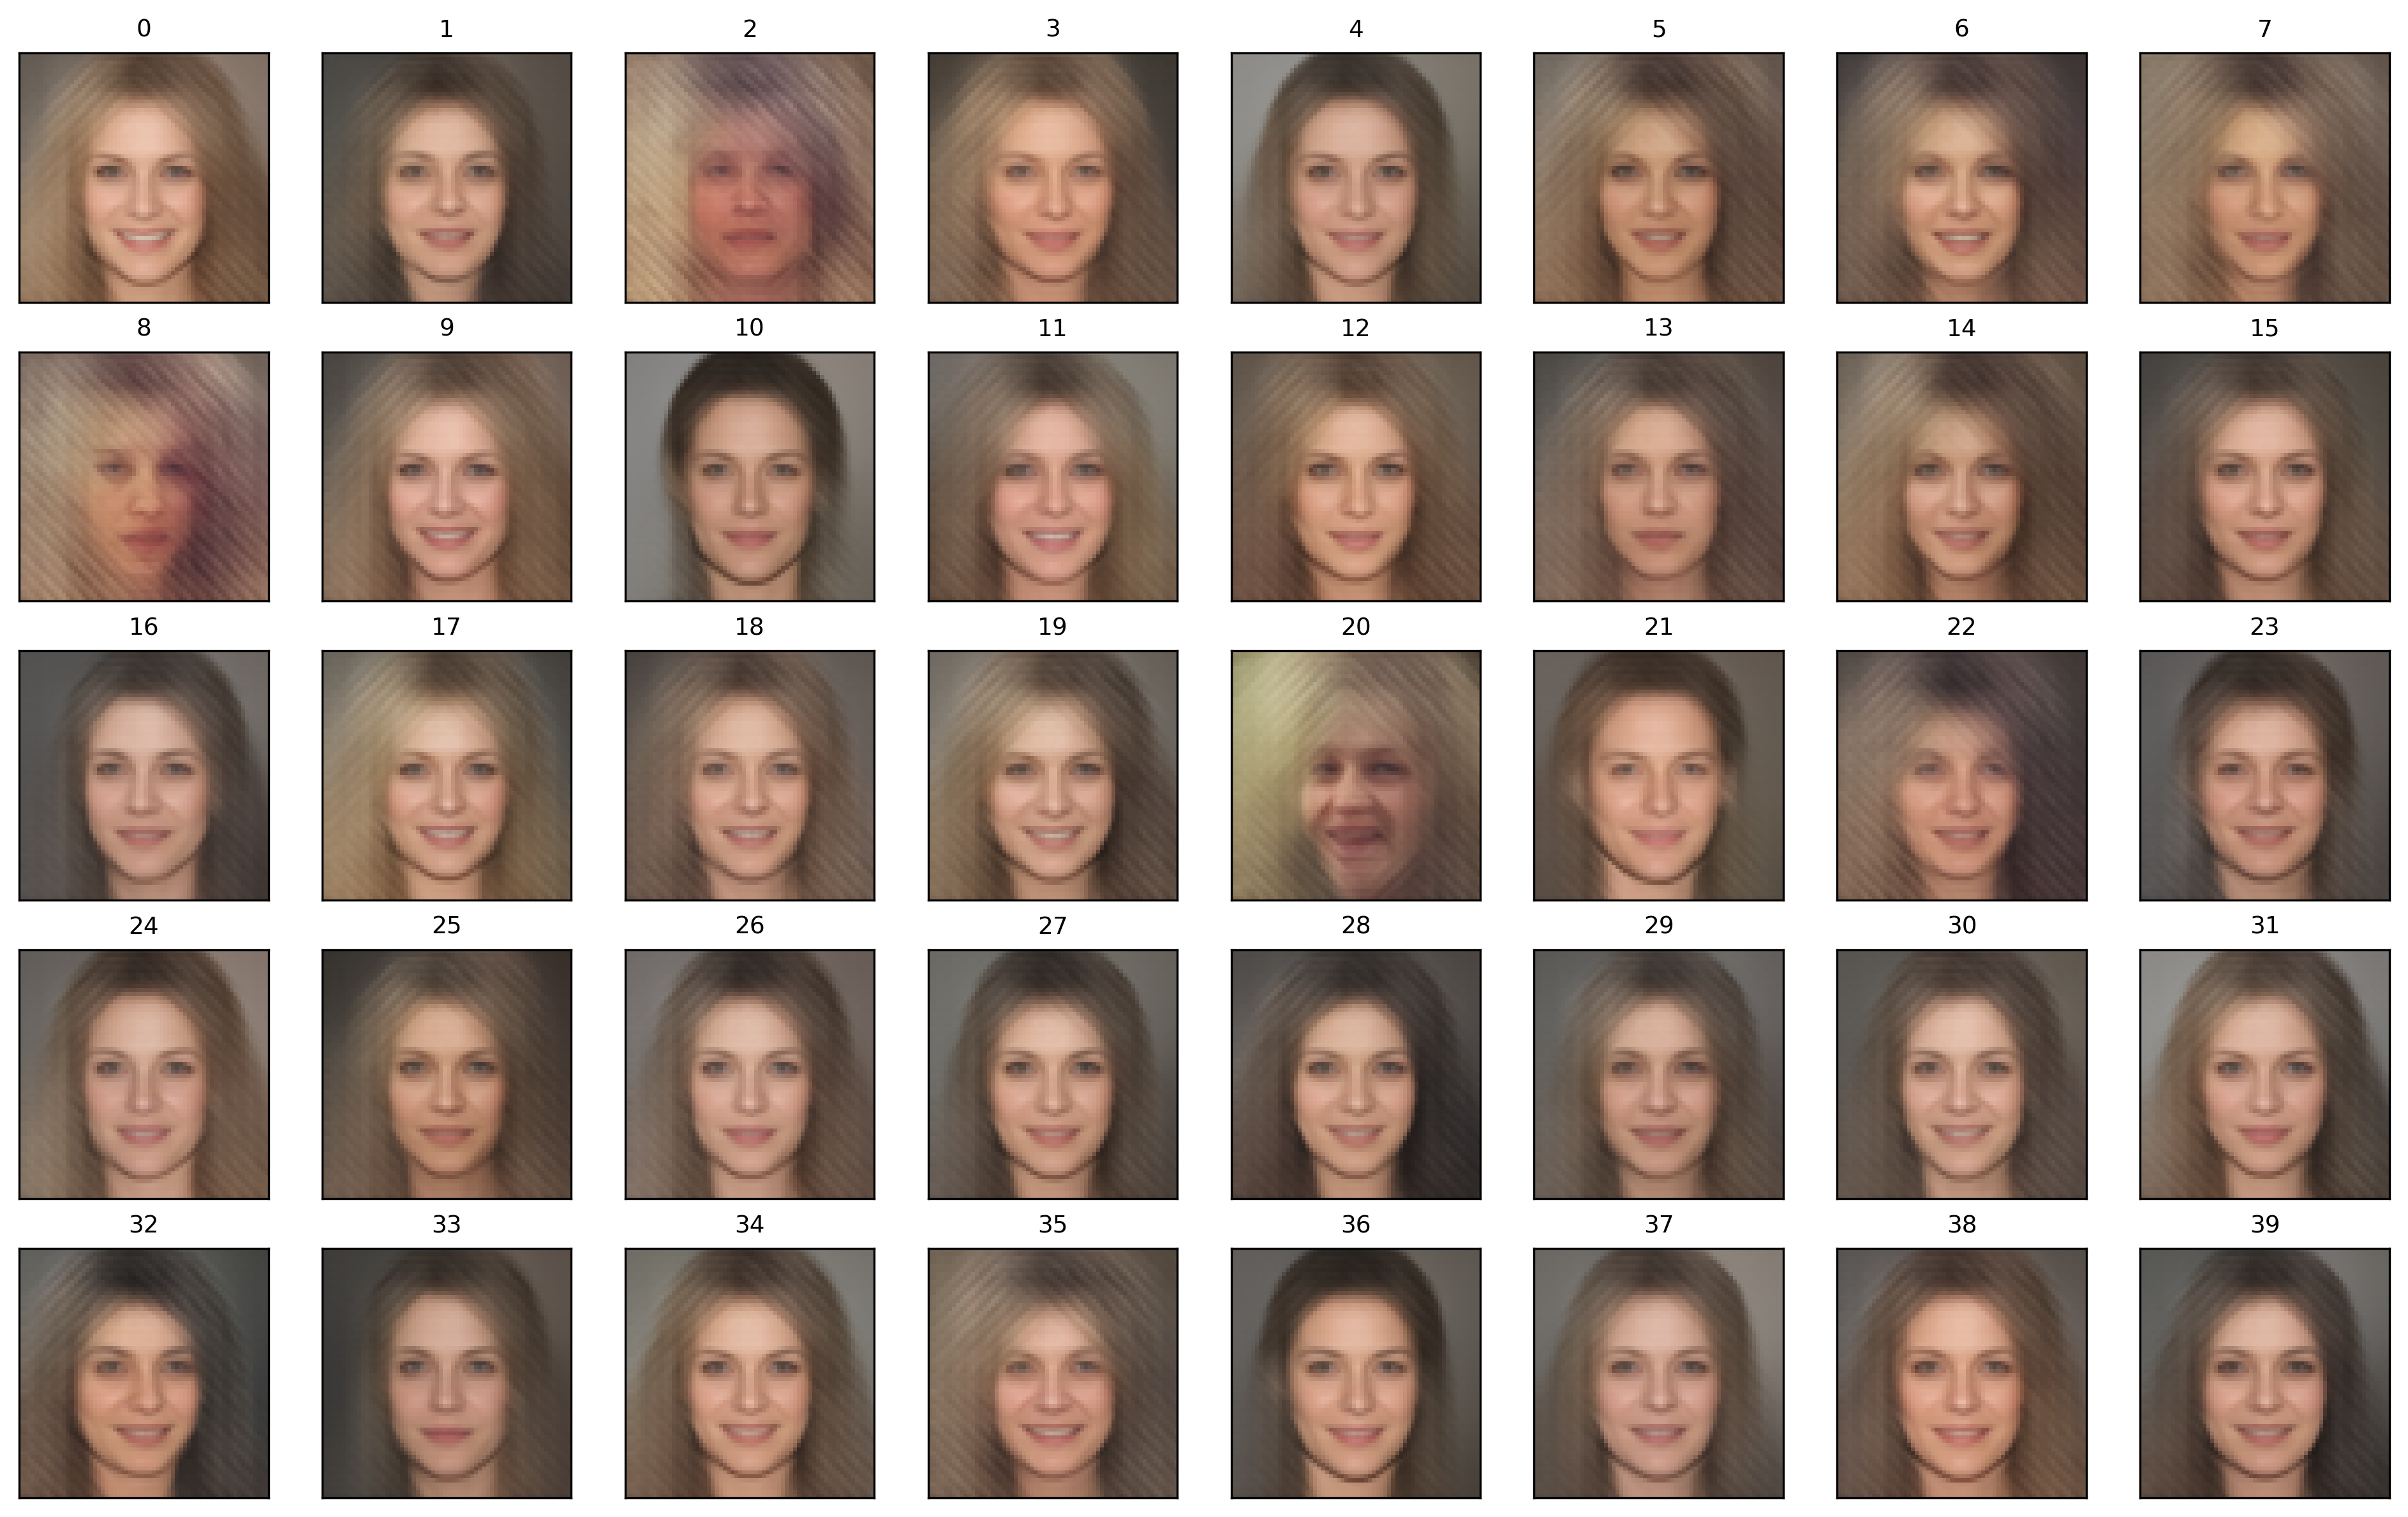

In [10]:
x_ = np.load("../data/results/pie_128_celeba_april_samples.npy")

plt.figure(figsize=(8*2.,5*2.))
for i in range(40):
    ax = plt.subplot(5,8, i+1)
    plt.imshow(trf(x_[i]))
    plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
    plt.title(str(i))
plt.show()


In [5]:
x_test = np.load("../data/samples/celeba/test.npy")[:8]
x_gen_af = np.load("../data/results/flow_512_celeba_april_samples.npy")[[3,7,13,17,21,25,36,38]]
x_gen_pie = np.load("../data/results/pie_512_celeba_april_samples.npy")[[0,1,4,6,12,20,27,34]]
x_gen_mf = np.load("../data/results/mf_512_celeba_april_samples.npy")[[37,25,32,33,19,8,34,13]]
x_gen_emf = np.load("../data/results/emf_512_celeba_april_samples.npy")[[6,32,19,34,1,28,31,16]]


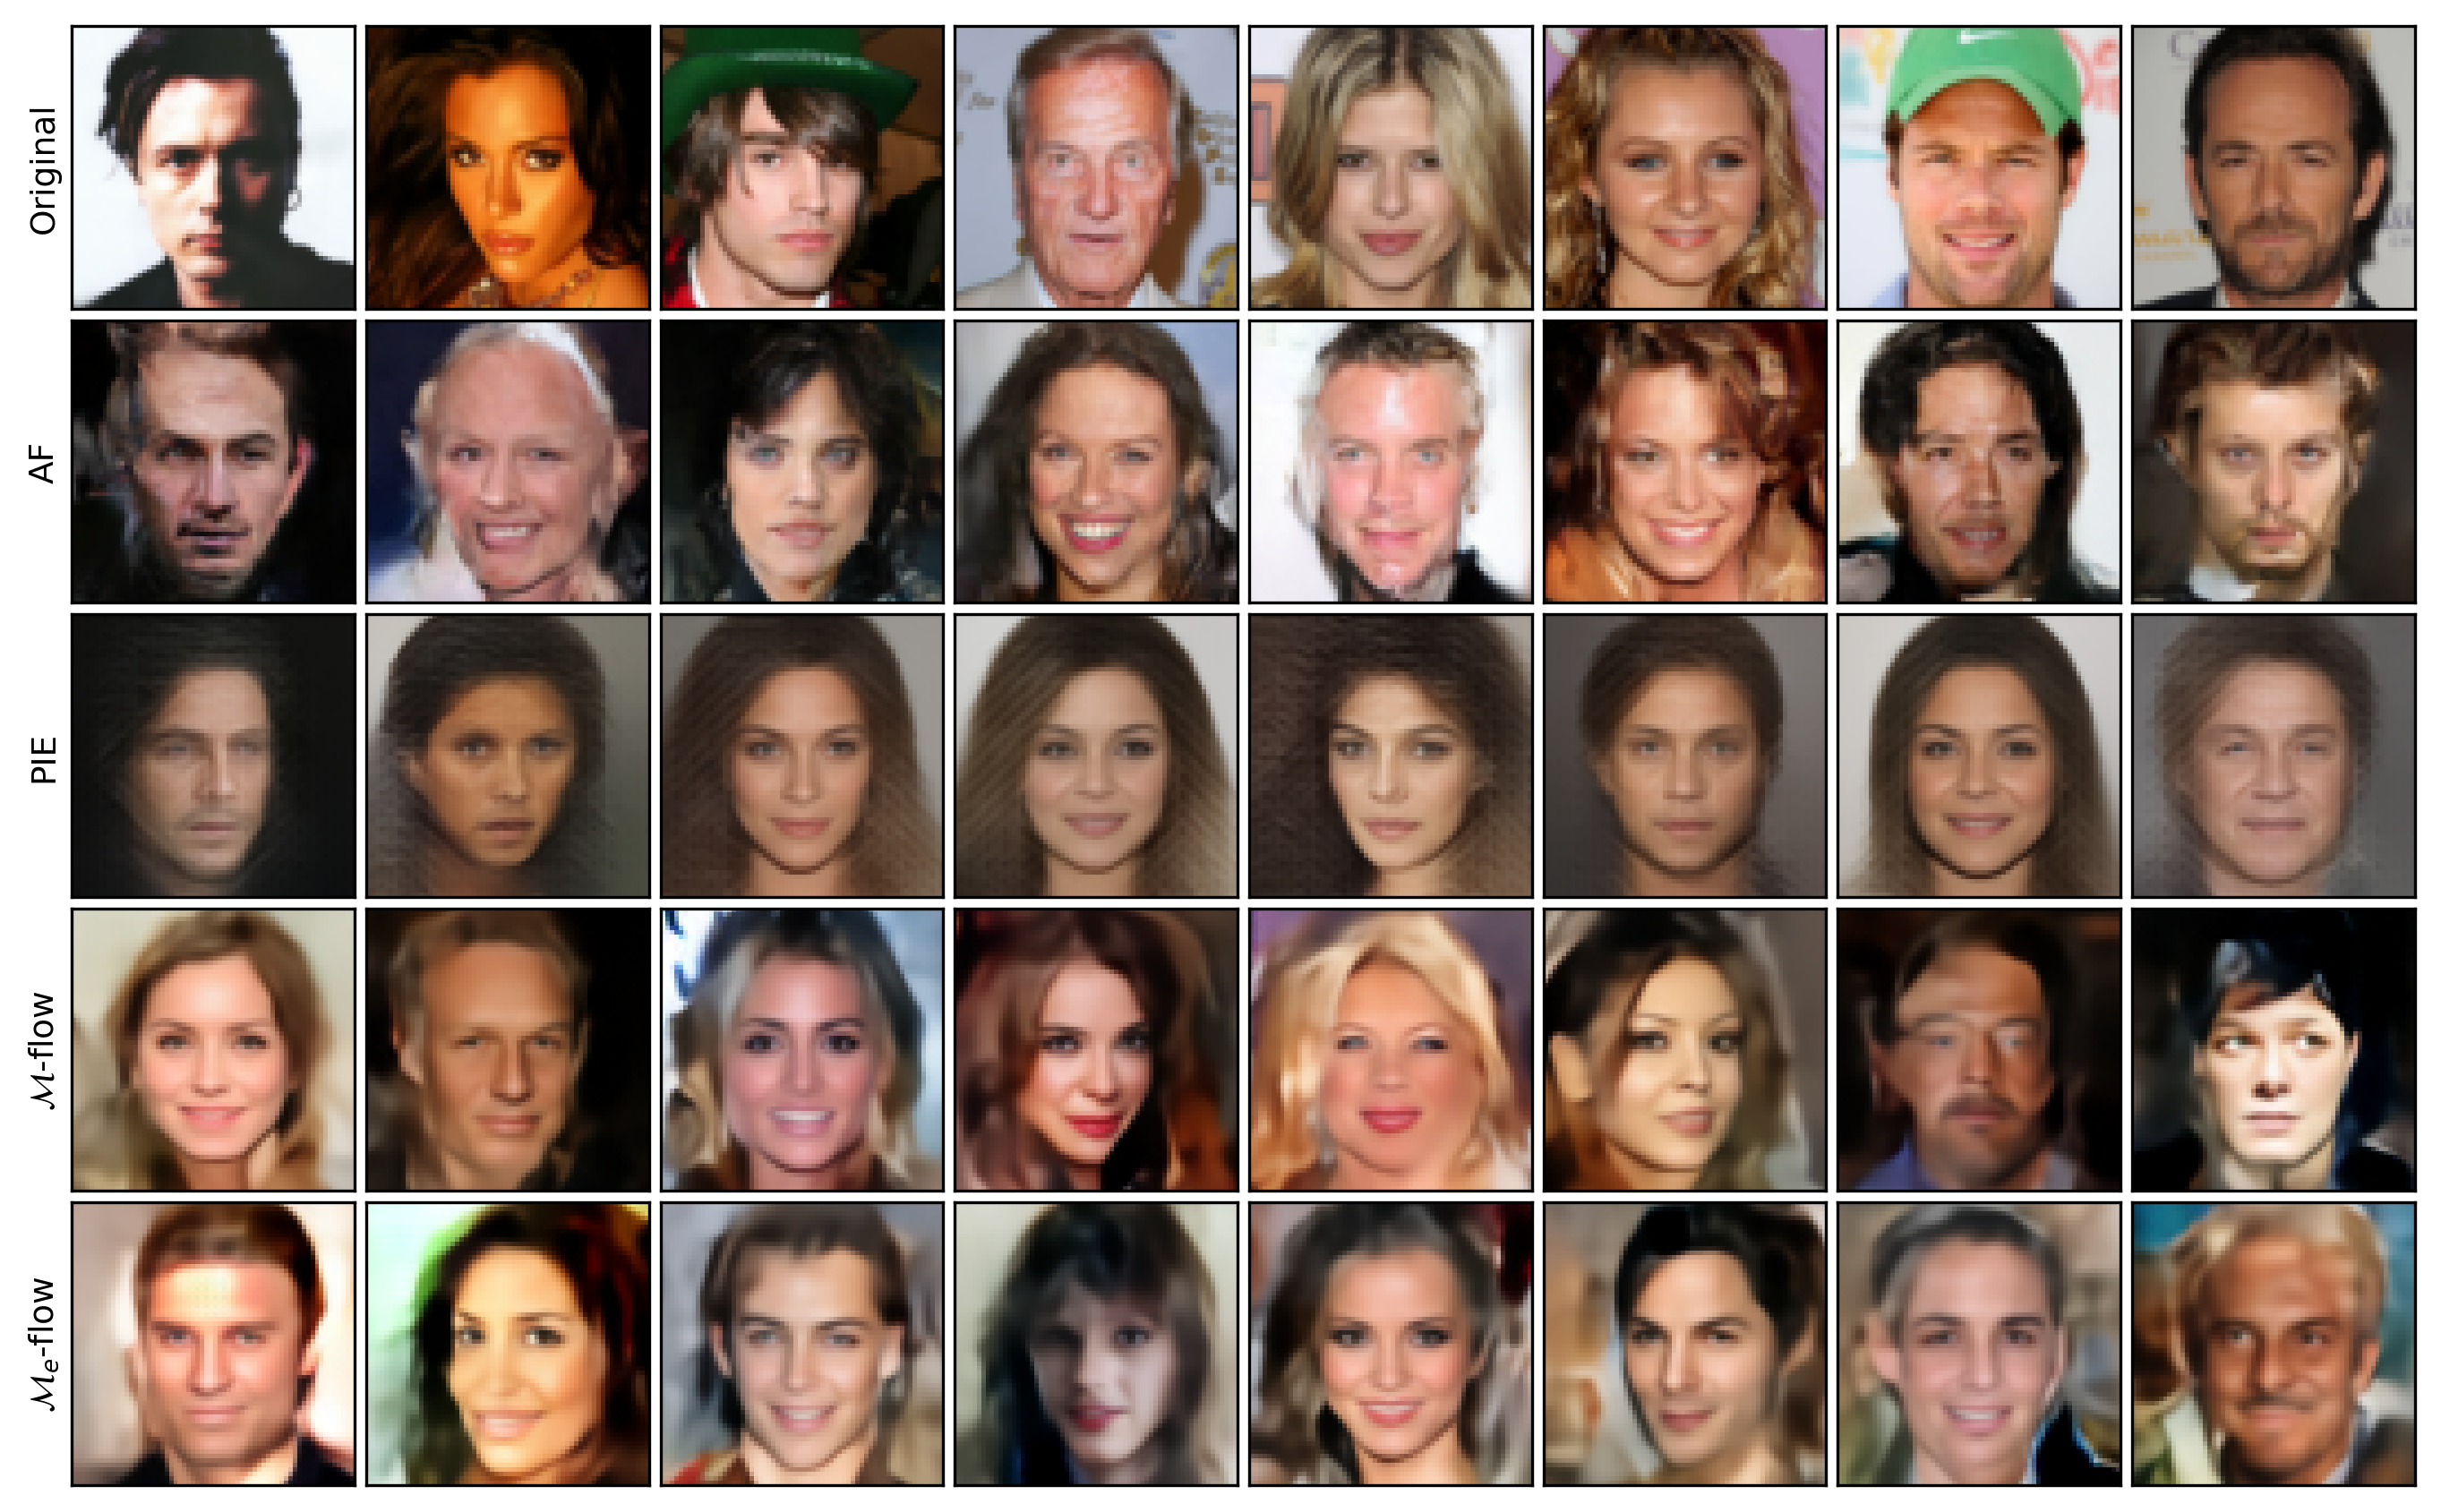

In [7]:
ncols = 8
nrows = 5

xs = [x_test, x_gen_af, x_gen_pie, x_gen_mf, x_gen_emf]
labels = ["Original", "AF", "PIE", r"$\mathcal{M}$-flow", r"$\mathcal{M}_e$-flow"]

fig, gs = ps.grid_width(ncols, nrows, width=ps.TEXTWIDTH, large_margin=0.04, small_margin=0.01, sep=0.007, t_space=False, b_space=False, r_space=False, l_space=True)

for i in range(ncols):
    for j, (x, label) in enumerate(zip(xs, labels)):
        ax = plt.subplot(gs[j*ncols + i])
        plt.imshow(trf(x[i]))
        plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
        if i == 0:
            plt.ylabel(label, labelpad=3)
    
plt.savefig("../figures/celeba_samples.pdf")


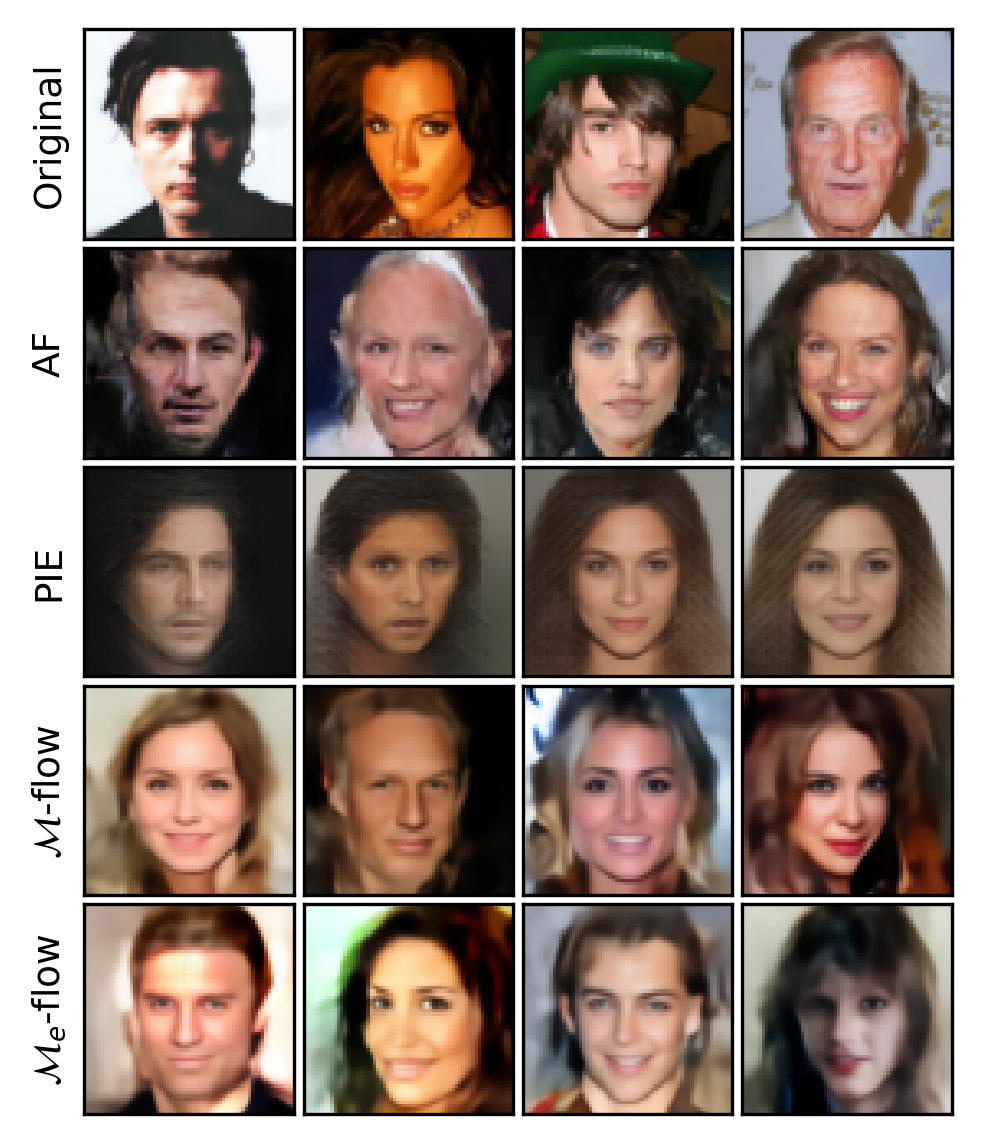

In [11]:
ncols = 4

fig, gs = ps.grid_width(ncols, nrows, width=0.35*ps.TEXTWIDTH, large_margin=0.06, small_margin=0.01, sep=0.007, t_space=False, b_space=False, r_space=False)

for i in range(ncols):
    for j, (x, label) in enumerate(zip(xs, labels)):
        ax = plt.subplot(gs[j*ncols + i])
        plt.imshow(trf(x[i]))
        plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
        if i == 0:
            plt.ylabel(label)
    
plt.savefig("../figures/celeba_samples_small.pdf")


## Test samples and projections to learned manifolds

In [12]:
test_idx = list(range(8, 16))
n_test = len(test_idx)

x_test = np.load("../data/samples/celeba/test.npy")[test_idx]
x_reco_pie = np.load("../data/results/pie_512_celeba_april_model_x_reco_test.npy")[test_idx]
x_reco_mf = np.load("../data/results/mf_512_celeba_april_model_x_reco_test.npy")[test_idx]
x_reco_emf = np.load("../data/results/emf_512_celeba_april_model_x_reco_test.npy")[test_idx]


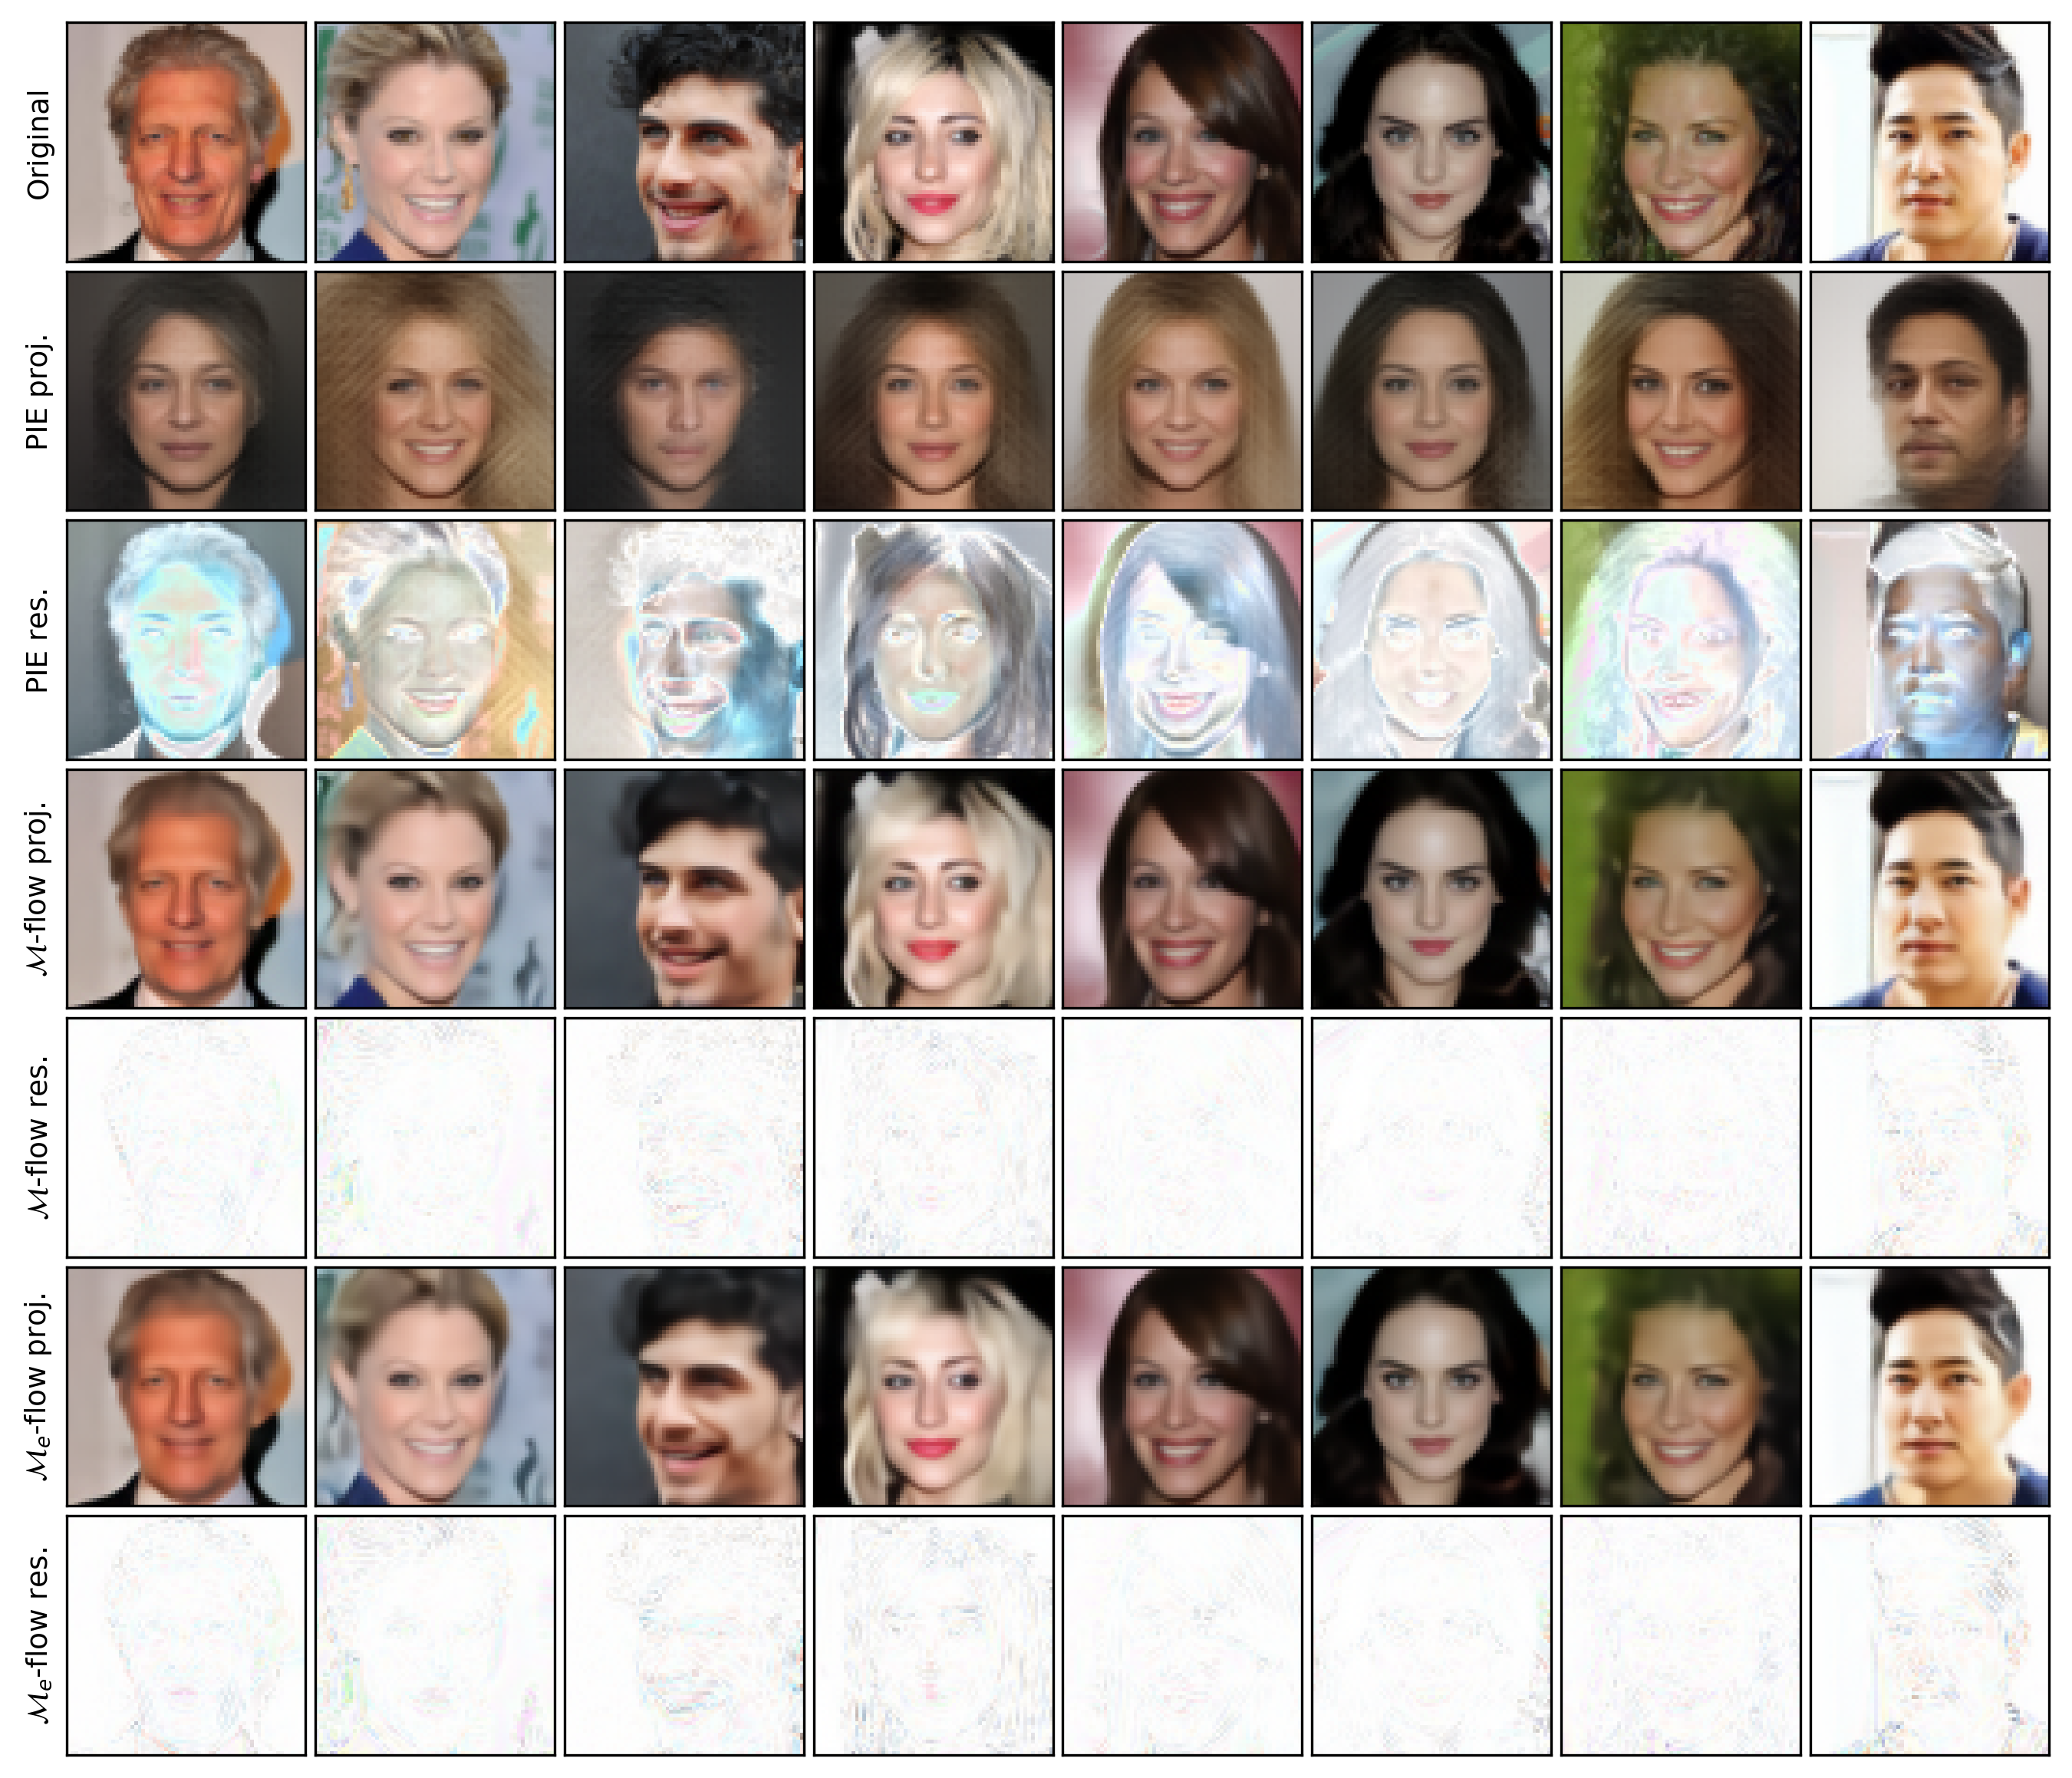

In [13]:
nrows = 7
enhance = 1
labels = ["Original", "PIE proj.", r"PIE res.", "$\mathcal{M}$-flow proj.", r"$\mathcal{M}$-flow res.", "$\mathcal{M}_e$-flow proj.", "$\mathcal{M}_e$-flow res."]

fig, gs = ps.grid_width(n_test, nrows, width=ps.TEXTWIDTH, large_margin=0.04, small_margin=0.01, sep=0.005, t_space=False, b_space=False, r_space=False, l_space=True)

for i in range(n_test):
    xs = [
        trf(x_test[i]),
        trf(x_reco_pie[i]),
        1. - enhance*np.abs(trf(x_reco_pie[i]) - trf(x_test[i])),
        trf(x_reco_mf[i]),
        1. - enhance*np.abs(trf(x_reco_mf[i]) - trf(x_test[i])),
        trf(x_reco_emf[i]),
        1. - enhance*np.abs(trf(x_reco_emf[i]) - trf(x_test[i]))
    ]
    
    for j, (x, label) in enumerate(zip(xs, labels)):
        ax = plt.subplot(gs[j * n_test + i])
        plt.imshow(x)
        plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
        if i == 0:
            plt.ylabel(label)
    
plt.savefig("../figures/celeba_projections.pdf")


In [ ]:
nrows = 5
ncols = 4
enhance = 1
labels = ["Original", "$\mathcal{M}$-flow", r"Residual", "$\mathcal{M}_e$-flow", "Residual"]

fig, gs = ps.grid_width(ncols, nrows, width=0.33 * ps.TEXTWIDTH, large_margin=0.06, small_margin=0.01, sep=0.005, t_space=False, b_space=False, r_space=False, l_space=True)

for i in range(ncols):
    xs = [
        trf(x_test[i]),
        trf(x_reco_mf[i]),
        1. - enhance*np.abs(trf(x_reco_mf[i]) - trf(x_test[i])),
        trf(x_reco_emf[i]),
        1. - enhance*np.abs(trf(x_reco_emf[i]) - trf(x_test[i]))
    ]
    
    for j, (x, label) in enumerate(zip(xs, labels)):
        ax = plt.subplot(gs[j * ncols + i])
        plt.imshow(x)
        plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
        if i == 0:
            plt.ylabel(label)
    
plt.savefig("../figures/celeba_projections_small.pdf")
